In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [174]:
sample_submission = pd.read_csv('sample_submission.csv')

In [113]:
validate = pd.read_csv('test_transaction.csv')

In [30]:
output = pd.read_csv('train_transaction.csv')

In [54]:
output_dummy = pd.get_dummies(output)
output_dummy.fillna(0, inplace=True)

In [55]:
output_dummy.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000,0,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,...,1,0,0,1,0,0,0,0,0,0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0,1,0,1,0,0,0,0,0,0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,1,0,1,0,1,0,1,0,1,0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0,1,1,0,0,0,0,0,0,0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
data = pd.read_csv('train_identity.csv')
data.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
missing_values = data.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

id_24         96.725281
id_25         96.448774
id_07         96.435219
id_08         96.435219
id_26         96.432509
id_21         96.430701
id_22         96.427087
id_27         96.427087
id_23         96.427087
id_18         69.033850
id_04         55.270815
id_03         55.270815
id_10         48.896680
id_09         48.896680
id_33         47.753601
id_30         43.888819
id_32         43.870746
id_34         43.823758
id_14         42.103266
DeviceInfo    16.904017
id_13         13.153091
id_16         10.008494
id_06          4.849728
id_05          4.849728
id_20          3.123814
id_19          3.108452
id_17          3.078633
id_31          2.444292
DeviceType     2.297002
id_02          2.264471
id_15          2.162362
id_11          2.162362
id_28          2.162362
id_29          2.162362
id_35          2.162362
id_36          2.162362
id_37          2.162362
id_38          2.162362
dtype: float64 %


In [5]:
data.fillna(0, inplace=True)

In [6]:
missing_values = data.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

Series([], dtype: float64) %


In [7]:
data.dtypes

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [10]:
data['id_12'].replace(['NotFound', 'Found'], [0, 1], inplace=True)

In [27]:
dummy_data = pd.get_dummies(data)

In [28]:
dummy_data

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,DeviceInfo_rv:59.0,DeviceInfo_rv:60.0,DeviceInfo_verykool,DeviceInfo_verykoolS5019,DeviceInfo_verykoolS5525,DeviceInfo_verykools4009,DeviceInfo_verykools5004,DeviceInfo_verykools5034,DeviceInfo_verykools5035,DeviceInfo_xs-Z47b7VqTMxs
0,2987004,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2987008,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2987011,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110661,3404525,0.0,985.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
110662,3404536,0.0,114486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
110663,3404546,-5.0,386272.0,0.0,0.0,6.0,-13.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
110664,3404547,-5.0,818972.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


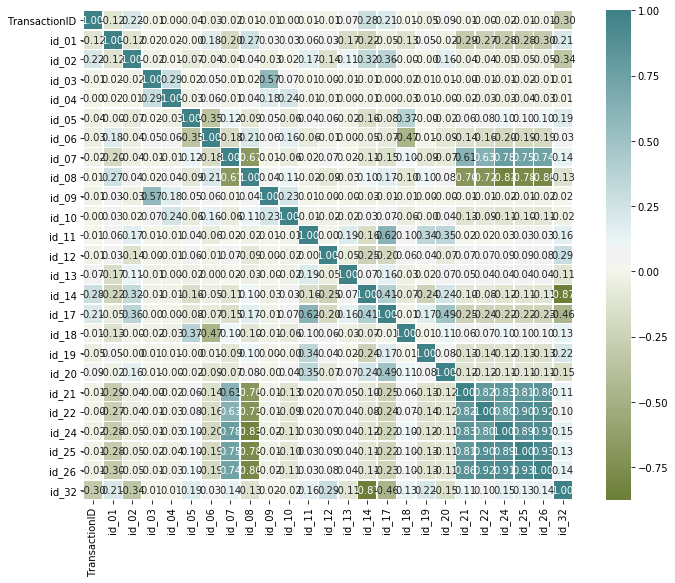

In [29]:
plt.figure(figsize=(12,9))

corr = data.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.diverging_palette(100,200, as_cmap=True), square=True);

In [88]:
X

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000,0,86400,68.500,13926,0.0,150.0,142.0,315.0,87.0,...,1,0,0,1,0,0,0,0,0,0
1,2987001,0,86401,29.000,2755,404.0,150.0,102.0,325.0,87.0,...,0,1,0,1,0,0,0,0,0,0
2,2987002,0,86469,59.000,4663,490.0,150.0,166.0,330.0,87.0,...,1,0,1,0,1,0,1,0,1,0
3,2987003,0,86499,50.000,18132,567.0,150.0,117.0,476.0,87.0,...,0,1,1,0,0,0,0,0,0,0
4,2987004,0,86506,50.000,4497,514.0,150.0,102.0,420.0,87.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417554,3404554,0,10540759,335.000,2538,476.0,150.0,166.0,126.0,87.0,...,1,0,1,0,1,0,1,0,0,1
417555,3404555,0,10540766,160.500,6019,583.0,150.0,226.0,269.0,87.0,...,0,1,0,1,0,1,0,1,0,1
417556,3404556,0,10540775,230.079,5059,138.0,200.0,226.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
417557,3404557,0,10540789,105.000,6697,111.0,150.0,195.0,299.0,87.0,...,1,0,1,0,0,0,0,0,0,0


In [96]:
%%time
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

colsToRemove = duplicate_columns(output_dummy)
print(colsToRemove)

['P_emaildomain_prodigy.net.mx', 'P_emaildomain_servicios-ta.com']
CPU times: user 37.3 s, sys: 3.26 s, total: 40.6 s
Wall time: 41.7 s


### Linear regression

In [80]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

X = output_dummy.copy()

y = output_dummy['isFraud']
del X['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [94]:
roc_auc_score(np.array(y_test), y_pred)

0.8522579025128959

In [81]:
roc_auc_score(np.array(y_train), y_pred_train)

0.8508280644573006

In [ ]:
test_

### LightGBM

In [151]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.7,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
roc_auc_score(np.array(y_test), y_pred)

Starting training...
[LightGBM] [Info] Number of positive: 11740, number of negative: 322307
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.918844
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.785317
[LightGBM] [Debug] init for col-wise cost 0.280774 seconds, init for row-wise cost 0.663582 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 32880
[LightGBM] [Info] Number of data points in the train set: 334047, number of used features: 520
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035145 -> initscore=-3.312503
[LightGBM] [Info] Start training from score -3.312503
[LightGBM] [Debug] Re-bagging, using 233833 data to train
[LightGBM] 

0.8959883061652951

### XGB

In [133]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
xgb_preds = bst.predict(dtest)

[23:51:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [135]:
roc_auc_score(np.array(y_test), xgb_preds)

0.6959683226535566

### Catboost

In [184]:
X_train

array([[ 0.97336186,  0.98668526, -0.31883866, ..., -0.37258714,
        -0.23516814,  1.59664454],
       [-0.98892171, -0.99909954, -0.03993257, ..., -0.37258714,
        -0.23516814, -0.62631348],
       [ 0.76642012,  0.79191732, -0.15640342, ..., -0.37258714,
        -0.23516814, -0.62631348],
       ...,
       [-0.63751152, -0.76235958, -0.314471  , ..., -0.37258714,
        -0.23516814, -0.62631348],
       [-0.51360202, -0.63232067, -0.43330039, ..., -0.37258714,
        -0.23516814, -0.62631348],
       [-0.72026167, -0.83171584, -0.3768661 , ..., -0.37258714,
        -0.23516814, -0.62631348]])

In [183]:
from catboost import CatBoostClassifier, Pool

train_data = X_train

train_labels = y_train

eval_data = X_test

eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)

model = CatBoostClassifier(learning_rate=0.09,
                           eval_metric='AUC', n_estimators = 2000, loss_function = 'Logloss', metric_period = 700,
                          depth = 7, od_wait = 800)

model.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False)

print(model.get_best_iteration())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-183-b75a721e8b74>", line 18, in <module>
    model.fit(train_data,
  File "/Users/rustem/Library/Python/3.8/lib/python/site-packages/catboost/core.py", line 4300, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/rustem/Library/Python/3.8/lib/python/site-packages/catboost/core.py", line 1804, in _fit
    self._train(
  File "/Users/rustem/Library/Python/3.8/lib/python/site-packages/catboost/core.py", line 1258, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4154, in _catboost._CatBoost._train
  File "_catboost.pyx", l

KeyboardInterrupt: 

In [181]:
cat_preds = model.predict(eval_data)

In [182]:
cat_preds.shape

(83512,)

In [158]:
roc_auc_score(np.array(y_test), cat_preds)

0.7887860653326827

In [165]:
roclist = list()
for i in np.arange(0, 1, 0.01):
    stupid_preds = i*y_pred + (1-i)*cat_preds
    roclist.append([roc_auc_score(np.array(y_test), stupid_preds), i, 1 - i])

In [169]:
max(roclist)

[0.901691567424174, 0.85, 0.15000000000000002]

In [171]:
stupid_preds.shape

(83512,)

In [175]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': stupid_preds})
sub.head()

ValueError: array length 83512 does not match index length 172981